# Steps

1. Extract bilby samples for each event in GWTC-3
2. Get the covariance matrix for each event using bilby
3. Get covariance number for log_DL - log_Mc and log_DL - log_eta
4. Plot these numbers and see the variations. This will determine whether the numbers can be bineed according to masses or distance
5. Get median values for DL, Mc, eta and store them as param values for that event along with cov matrix in h5 file
6. Take events with $\Delta z / z < 0.5$ from MPSAC study

# Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
from pesummary.io import read
from pesummary.gw.fetch import fetch_open_samples
import numpy as np
from bilby.core.result import Result
import pandas as pd
import os
from glob import glob
import re
import h5py
import pylab as plt
from tqdm import tqdm
import itertools

# Get covariance matrices of GWTC-3

## Get samples

In [2]:
samples_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/GWTC_data_releases/'

In [3]:
data_files = glob(os.path.join(samples_dir, 'GWTC*', '*.h5'))

In [4]:
events_dict = {}
for file in data_files:
    event = re.findall('GW\d{6}_\d{6}', file)[0]
    cat = re.findall('GWTC-\d', file)[0]
    events_dict[event] = {'file':file, 'catalog':cat, 'posterior_samples':{}, 'median_values':{}}

In [5]:
with h5py.File(events_dict['GW190408_181802']['file'], 'r') as f:
    print(f['PublicationSamples']['posterior_samples'].dtype.names)

('log_likelihood', 'chi_eff', 'neff', 'total_mass_source', 'chi_p', 'Npts', 'spin_1y', 'final_mass', 'phi_2', 'phi_12', 'ra', 'phi_jl', 'tilt_2', 'cos_theta_jn', 'a_2', 'peak_luminosity', 'mass_1', 'mass_ratio', 'a_1', 'cos_tilt_1', 'final_mass_source', 'phase', 'inverted_mass_ratio', 'final_mass_source_non_evolved', 'radiated_energy', 'mass_2', 'p', 'mass_2_source', 'dec', 'psi', 'total_mass', 'theta_jn', 'redshift', 'iota', 'spin_1x', 'final_mass_non_evolved', 'chirp_mass', 'cos_iota', 'comoving_distance', 'spin_2y', 'tilt_1', 'spin_2z', 'mass_1_source', 'geocent_time', 'ps', 'final_spin_non_evolved', 'cos_tilt_2', 'final_spin', 'luminosity_distance', 'spin_1z', 'peak_luminosity_non_evolved', 'radiated_energy_non_evolved', 'chirp_mass_source', 'phi_1', 'symmetric_mass_ratio', 'spin_2x')


In [6]:
for event in tqdm(events_dict.keys()):
    cat = events_dict[event]['catalog']
    with h5py.File(events_dict[event]['file'], 'r') as f:
        if cat == 'GWTC-3':
            stype = 'C01:Mixed'
        elif cat == 'GWTC-2':
            stype = 'PublicationSamples'
        for param in ['chirp_mass', 'symmetric_mass_ratio', 'luminosity_distance', 'chirp_mass_source']:
            events_dict[event]['posterior_samples'][param] = f[stype]['posterior_samples'][param]
            events_dict[event]['posterior_samples']['log_'+param] = np.log(f[stype]['posterior_samples'][param])
        events_dict[event]['posterior_samples']['redshift'] = f[stype]['posterior_samples']['redshift']
        for param in events_dict[event]['posterior_samples'].keys():
            events_dict[event]['median_values'][param] = np.median(events_dict[event]['posterior_samples'][param])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [01:16<00:00,  1.08s/it]


## Calculate covariance matrices

In [9]:
for event in events_dict.keys():
    cov_params = ['chirp_mass', 'symmetric_mass_ratio', 'luminosity_distance']
    events_dict[event]['covariance_matrix_parameters'] = cov_params
    bilby_result = Result(posterior=pd.DataFrame(events_dict[event]['posterior_samples']), 
                          search_parameter_keys=cov_params)
    cov = bilby_result.covariance_matrix
    events_dict[event]['covariance_matrix'] = cov

In [10]:
cov_idxs = {param:i for param, i in zip(cov_params, range(3))}

## Plot as a func of inj params

In [11]:
param_labels = {'log_chirp_mass': '$\log \mathcal{M}_c$', 
                'log_symmetric_mass_ratio': '$\log \eta$', 
                'log_luminosity_distance': '$\log D_L$',
                'luminosity_distance': '$D_L$', 
                'symmetric_mass_ratio': '$\eta$', 
                'chirp_mass': '$\mathcal{M}_c$',
                'chirp_mass_source': '$\mathcal{M}_c^{source}$', 
                'redshift': '$z$'}

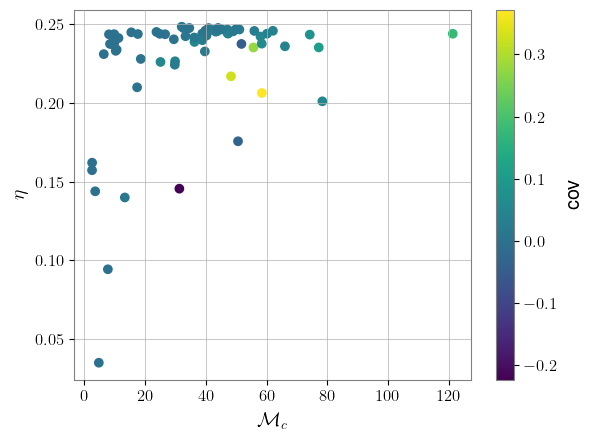

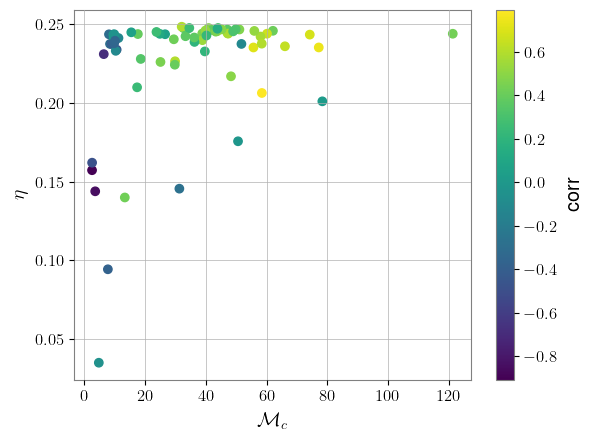

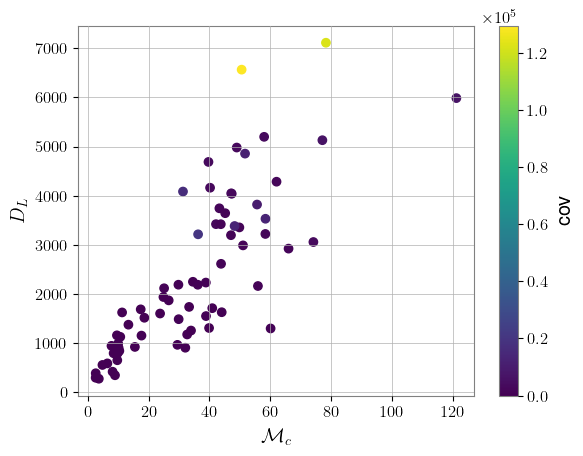

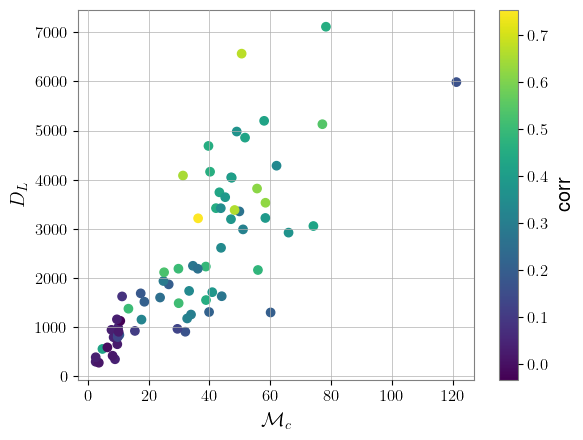

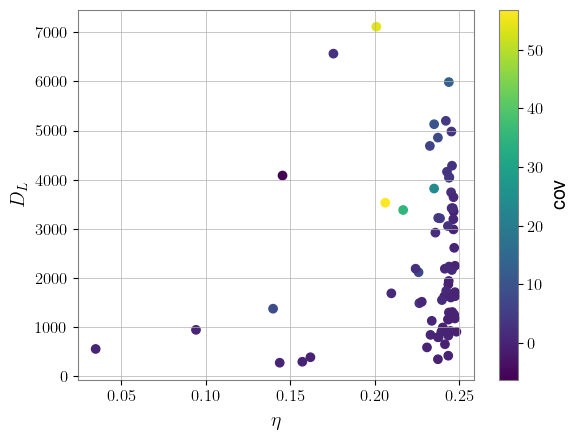

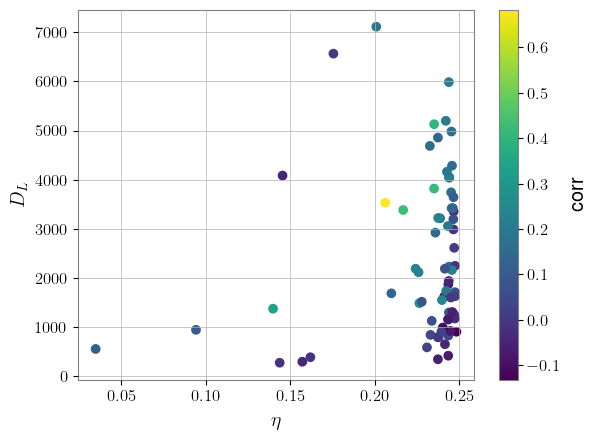

In [12]:
for p1, p2 in itertools.combinations(cov_params, 2):
    med_values = {}
    covs = [events_dict[event]['covariance_matrix'][cov_idxs[p1],cov_idxs[p2]] for event in events_dict.keys()]
    corrs = [events_dict[event]['covariance_matrix'][cov_idxs[p1],cov_idxs[p2]]/np.sqrt(events_dict[event]['covariance_matrix'][cov_idxs[p1],cov_idxs[p1]] * events_dict[event]['covariance_matrix'][cov_idxs[p2],cov_idxs[p2]]) for event in events_dict.keys()]
    for p in [p1, p2]:
        med_values[p] = [events_dict[event]['median_values'][p] for event in events_dict.keys()]
    plt.figure()
    plt.scatter(med_values[p1], med_values[p2], c=covs)
    plt.xlabel(param_labels[p1])
    plt.ylabel(param_labels[p2])
    plt.colorbar(label='cov')

    plt.figure()
    plt.scatter(med_values[p1], med_values[p2], c=corrs)
    plt.xlabel(param_labels[p1])
    plt.ylabel(param_labels[p2])
    plt.colorbar(label='corr')